<a href="https://colab.research.google.com/github/Narissarach/Project_eye/blob/main/modelOCTnoiseRes2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ModelOCT 

In [1]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import glob
import PIL
import plotly
import plotly.graph_objs as go
import pandas as pd
from numpy import array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, AveragePooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D)
import time
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
import requests
from IPython.display import Image
from io import BytesIO  
import pickle as p 
import plotly.graph_objs as go  
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
K.image_data_format()
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

## เตรียมชุดของข้อมูล

In [3]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่า Mounted at /content/drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์
path = '/content/drive/My Drive/focusnew'  # data เราอยู่โฟล์เดอร์ไหน

In [5]:
batch_size = 8   # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 256  # ความสูงของรูปภาพแต่ละรูป
img_width = 256   # ความกว้างของรูปภาพแต่ละรูป

num_classes = 4

## Train

In [6]:
# Train
train_dir = "/content/drive/My Drive/focusnew/train"
train_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 502 images belonging to 4 classes.


In [7]:
print('Train')
ids, counts = np.unique(train_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนภาพของคลาส

Train
[0 1 2 3]
[131 117 123 131]


In [8]:
train_set[0][0][0].shape   # W*H*3 (3 Channel RGB) 

(256, 256, 3)

## Validation

In [9]:
# Validation
val_dir ="/content/drive/My Drive/focusnew/validation"
val_datagen = ImageDataGenerator(rescale = 1./255)

val_set = val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 63 images belonging to 4 classes.


In [10]:
print('Validation')
ids, counts = np.unique(val_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนข้อมูลของคลาส

Validation
[0 1 2 3]
[16 15 15 17]


## Test

In [11]:
# Test
test_dir ="/content/drive/My Drive/focusnew/test"
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = tf.keras.utils.image_dataset_from_directory(test_dir,image_size=(img_height, img_width))

Found 63 files belonging to 4 classes.


In [12]:
class_names = test_set.class_names
print(class_names)

['CSC', 'NORMAL', 'PCV', 'VKH']


## Setup และโหลด Dataset

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
target_img_shape = (256,256) 
train_dir = "/content/drive/My Drive/focusnew/train" #train dir
val_dir = "/content/drive/My Drive/focusnew/validation" #validation dir

In [15]:
#Process input แปลงข้อมูลภาพให้อยู่ในสเกลสำหรับ Model VGG16
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# อ่านไฟล์ภาพจากโฟลเดอร์ ลดสเล จัดแบ่งเป็น Batch
train_set = train_datagen.flow_from_directory(train_dir,
                                              target_size = target_img_shape, # ลดสเกลภาพ
                                              batch_size = 8,                 # แบ่งเป็น batch ละ 8 ภาพ
                                              class_mode = 'sparse')  

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_set = val_datagen.flow_from_directory(val_dir,
                                              target_size = target_img_shape,
                                              batch_size = 8,
                                              class_mode = 'sparse')  

Found 502 images belonging to 4 classes.
Found 63 images belonging to 4 classes.


## Visualization

{'CSC': 0, 'NORMAL': 1, 'PCV': 2, 'VKH': 3}


(8, 256, 256, 3)
(8,)
class: 1.0


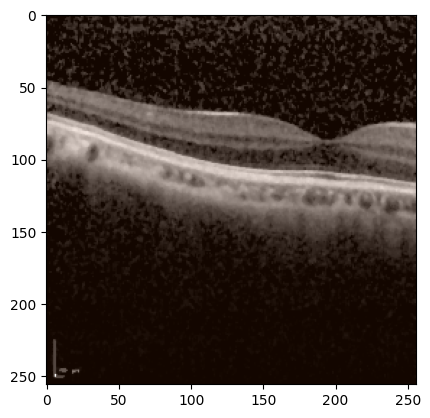

In [16]:
print(train_set.class_indices)
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)

  img = image_batch[0] - image_batch[0].min()
  img /= 255.0
  plt.imshow(img)
  print('class:', labels_batch[0])
  break

In [17]:
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

for i in ids:
  print('{:>8} = {}' . format(labels[i], counts[i]))

     CSC = 16
  NORMAL = 15
     PCV = 15
     VKH = 17


In [18]:
_, train_count = np.unique(train_set.classes, return_counts=True)
_, val_count = np.unique(val_set.classes, return_counts=True)

print('สัดส่วน Validation/Training set:', val_count/train_count*100)

สัดส่วน Validation/Training set: [12.21374046 12.82051282 12.19512195 12.97709924]


## สร้างโมเดล CNN

In [19]:
in_shape = (target_img_shape[0], target_img_shape[1],3)
in_shape

(256, 256, 3)

In [20]:
base_model = ResNet50(include_top = False,
                      weights='imagenet',        # Load weight
                      input_shape=in_shape)

In [21]:
model = Sequential()

model.add(base_model) # ตัวฐาน (Pre-trained)
model.add(Flatten())
model.add(Dense(128, activation='relu')) 

model.add(Dense(64, activation='relu')) 

model.add(Dense(4, activation='softmax')) # 4 คลาส

model.summary() # ดูสรุป

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 40,373,572
Trainable params: 40,320,452
Non-trainable params: 53,120
_________________________________________________________________


In [22]:
base_model.trainable = False # Freeze ส่วนที่เป็นฐาน (ResNet50)

In [23]:
print("Trainable..\n---")
for variable in model.trainable_variables:
  print(variable.name)

Trainable..
---
dense/kernel:0
dense/bias:0
dense_1/kernel:0
dense_1/bias:0
dense_2/kernel:0
dense_2/bias:0


In [24]:
model.summary() # ดูสรุป

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 40,373,572
Trainable params: 16,785,860
Non-trainable params: 23,587,712
_________________________________________________________________


### Compile และ Train

In [25]:
from keras.api._v2.keras import callbacks
import time
model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

start = time.time()

history = model.fit(train_set,
                    validation_data=val_set, 
                    epochs=20,verbose=1)

end = time.time()
print("Time Taken: {:.2f} minutes".format((end-start)/60))

Epoch 1/20
63/63 [==============================] - 188s 3s/step - loss: 10.5486 - accuracy: 0.5817 - val_loss: 1.7008 - val_accuracy: 0.8095
Epoch 2/20
63/63 [==============================] - 161s 3s/step - loss: 1.2995 - accuracy: 0.8606 - val_loss: 3.2638 - val_accuracy: 0.7778
Epoch 3/20
63/63 [==============================] - 164s 3s/step - loss: 0.9857 - accuracy: 0.9024 - val_loss: 5.5620 - val_accuracy: 0.6825
Epoch 4/20
63/63 [==============================] - 161s 3s/step - loss: 0.2814 - accuracy: 0.9681 - val_loss: 0.9715 - val_accuracy: 0.8889
Epoch 6/20
63/63 [==============================] - 161s 3s/step - loss: 8.7128e-04 - accuracy: 1.0000 - val_loss: 0.9336 - val_accuracy: 0.9365
Epoch 7/20
63/63 [==============================] - 163s 3s/step - loss: 1.6261e-05 - accuracy: 1.0000 - val_loss: 0.8894 - val_accuracy: 0.9524
Epoch 8/20
63/63 [==============================] - 162s 3s/step - loss: 6.3969e-06 - accuracy: 1.0000 - val_loss: 0.8889 - val_accuracy: 0.9524


### Save Model

In [26]:
modelOCT = '/Model'
if not os.path.exists(path+modelOCT):
    os.makedirs(path+modelOCT)
os.makedirs('/content/drive/My Drive/focusnew/savemodel/', exist_ok=True)
model.save('/content/drive/MyDrive/focusnew/savemodel/modelOCTnoiseRes2.h5')

with open('history_model', 'wb') as file:
   p.dump(history.history, file)

filepath='modelOCTnoiseRes2.h5'
model.save(filepath)
filepath_model = 'modelOCTnoiseRes2.json'
filepath_weights = 'weightsmodelOCTnoiseRes2.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
   json_file.write(model_json)

model.save_weights('weightsmodelOCTnoiseRes2.h5')
print("Saved model to disk")
     

Saved model to disk


### Load Model

In [27]:
with open('history_model', 'rb') as file:
   his = p.load(file)

h1 = go.Scatter(y=his['val_accuracy'],
mode="lines", line=dict(
width=2,
color='blue'),
name="val_accuracy"
)
h2 = go.Scatter(y=his['val_loss'],
mode="lines", line=dict(
width=2,
color='red'),
name="val_loss"
)

data = [h1,h2]
layout1 = go.Layout(title='Loss',
xaxis=dict(title='epochs'),
yaxis=dict(title=' '))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testOCT")
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, 'r') as f:
   loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print("Loaded model from disk")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 40,373,572
Trainable params: 16,785,860
Non-trainable params: 23,587,712
_________________________________________________________________
Loaded model from disk


## ประเมิน

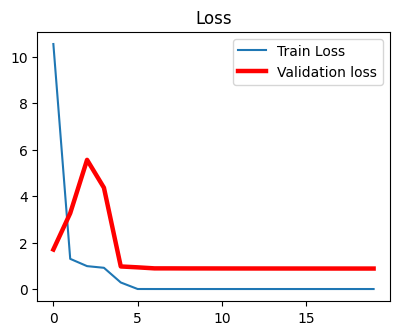

In [28]:
plt.figure(figsize = (10, 3.5))
plt.subplot(1, 2 , 1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], 'r', lw = 3.2, label = 'Validation loss')
plt.legend()

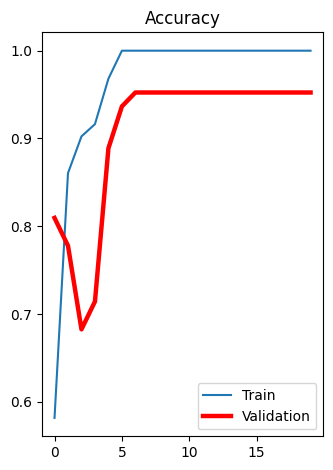

In [29]:
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], 'r', lw = 3.2, label = 'Validation')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
acc = model.evaluate(val_set, steps = len(val_set), verbose = 0)
print('score = {:.3f}' .format(acc[1]))

score = 0.952


### Prediction

In [31]:
import requests
from IPython.display import Image
from io import BytesIO
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing import image 
import keras.utils as image
from keras.models import load_model

In [32]:
train_set.class_indices

{'CSC': 0, 'NORMAL': 1, 'PCV': 2, 'VKH': 3}

1/1 [==============================] - 1s 1s/step
CSC tf.Tensor(0.47536692, shape=(), dtype=float32) NORMAL tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


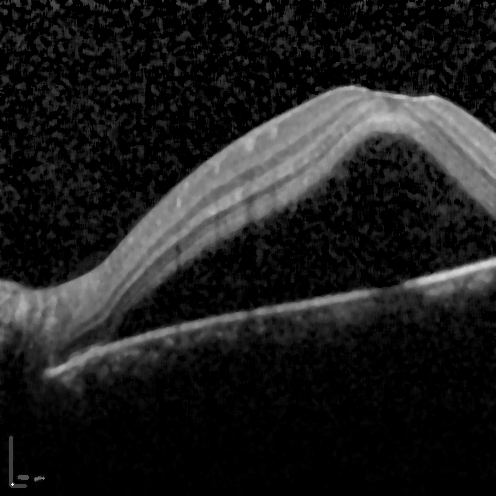

AI CSC มีความมั่นใจ 47.54%.


In [33]:
# CSC
test_path = ('/content/drive/My Drive/FocusOCT2022/test/CSC/filtered_JP6908 04-09-17 LE_001.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"NORMAL",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "NORMAL"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 246ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) NORMAL tf.Tensor(0.47536692, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


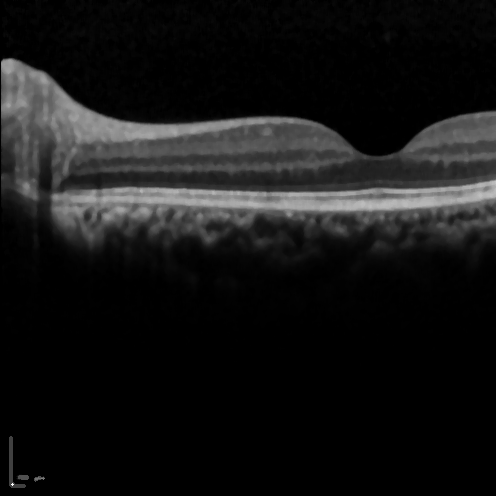

AI NORMAL มีความมั่นใจ 47.54%.


In [34]:
# Normal
test_path = ('/content/drive/My Drive/FocusOCT2022/test/NORMAL/filtered_JX9055 03-02-19 LE_000.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"NORMAL",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "NORMAL"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 263ms/step
CSC tf.Tensor(0.1748777, shape=(), dtype=float32) NORMAL tf.Tensor(0.1748777, shape=(), dtype=float32) PCV tf.Tensor(0.47536686, shape=(), dtype=float32) VKH tf.Tensor(0.1748777, shape=(), dtype=float32)


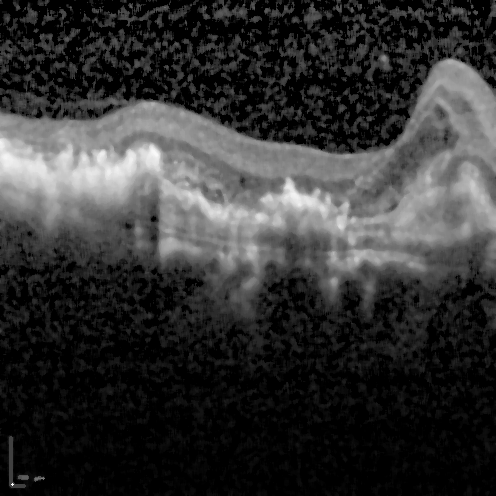

AI PCV มีความมั่นใจ 47.54%.


In [35]:
# PCV
test_path = ('/content/drive/My Drive/FocusOCT2022/test/PCV/filtered_JW0334 04-09-18 RE_000.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"NORMAL",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "NORMAL"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 245ms/step
CSC tf.Tensor(0.1748777, shape=(), dtype=float32) NORMAL tf.Tensor(0.1748777, shape=(), dtype=float32) PCV tf.Tensor(0.1748777, shape=(), dtype=float32) VKH tf.Tensor(0.47536686, shape=(), dtype=float32)


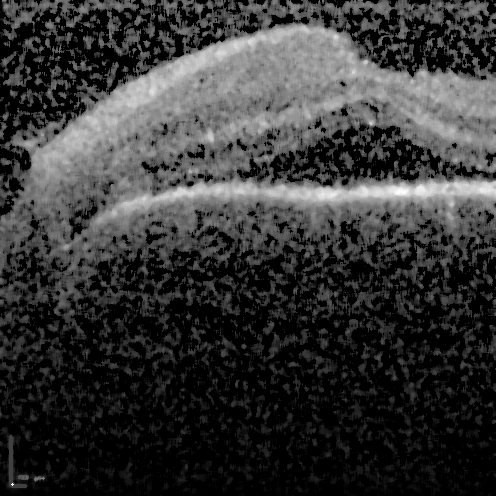

AI VKH มีความมั่นใจ 47.54%.


In [36]:
# VKH
test_path = ('/content/drive/My Drive/FocusOCT2022/test/VKH/filtered_KG1178 26-08-20 LE_001.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"NORMAL",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "NORMAL"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

### Testing

In [37]:
y_test = []; y_pred = []
class_names = test_set.class_names
for images, labels in test_set:
  for i in range(len(list(labels))):
    img_array = keras.preprocessing.image.img_to_array(images[i])
    X_test = tf.expand_dims(img_array, 0)
    score = predict_model.predict(X_test)
    if score[0][0]==np.max(score):
      eye = "CSC"
    elif score[0][1]==np.max(score):
      eye = "NORMAL"
    elif score[0][2]==np.max(score):
      eye = "PCV"
    elif score[0][3]==np.max(score):
      eye = "VKH"
    y_pred.append(eye)
    y_test.append(class_names[labels[i]])

1/1 [==============================] - 0s 277ms/step


In [38]:
print(y_test)
print(len(y_test))

['VKH', 'NORMAL', 'PCV', 'NORMAL', 'CSC', 'VKH', 'CSC', 'PCV', 'CSC', 'VKH', 'CSC', 'NORMAL', 'VKH', 'VKH', 'NORMAL', 'CSC', 'CSC', 'PCV', 'PCV', 'CSC', 'NORMAL', 'CSC', 'VKH', 'CSC', 'NORMAL', 'VKH', 'CSC', 'PCV', 'CSC', 'CSC', 'VKH', 'PCV', 'NORMAL', 'CSC', 'PCV', 'PCV', 'CSC', 'VKH', 'VKH', 'VKH', 'NORMAL', 'NORMAL', 'PCV', 'PCV', 'VKH', 'NORMAL', 'VKH', 'PCV', 'NORMAL', 'PCV', 'NORMAL', 'VKH', 'NORMAL', 'PCV', 'VKH', 'VKH', 'PCV', 'NORMAL', 'CSC', 'CSC', 'VKH', 'PCV', 'NORMAL']
63


In [39]:
print(y_pred)
print(len(y_pred))

['VKH', 'NORMAL', 'PCV', 'NORMAL', 'CSC', 'NORMAL', 'CSC', 'PCV', 'CSC', 'VKH', 'CSC', 'NORMAL', 'VKH', 'VKH', 'CSC', 'CSC', 'CSC', 'CSC', 'CSC', 'CSC', 'NORMAL', 'VKH', 'VKH', 'CSC', 'NORMAL', 'VKH', 'CSC', 'PCV', 'CSC', 'CSC', 'PCV', 'PCV', 'NORMAL', 'CSC', 'PCV', 'PCV', 'CSC', 'VKH', 'VKH', 'VKH', 'NORMAL', 'NORMAL', 'PCV', 'PCV', 'VKH', 'NORMAL', 'VKH', 'PCV', 'NORMAL', 'PCV', 'NORMAL', 'VKH', 'NORMAL', 'VKH', 'VKH', 'VKH', 'VKH', 'NORMAL', 'CSC', 'CSC', 'VKH', 'PCV', 'NORMAL']
63


## Confusion Matrix

In [40]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
confusion_matrix(y_test, y_pred)

array([[15,  0,  0,  1],
       [ 1, 14,  0,  0],
       [ 2,  0, 11,  2],
       [ 0,  1,  1, 15]])

In [42]:
cm = confusion_matrix(y_test, y_pred)

In [43]:
test_set.class_names

['CSC', 'NORMAL', 'PCV', 'VKH']

In [44]:
cm_df = pd.DataFrame(cm,
                     index = ['CSC', 'NORMAL', 'PCV', 'VKH'], 
                     columns = ['CSC', 'NORMAL', 'PCV', 'VKH'])

In [45]:
cm_df

,CSC,NORMAL,PCV,VKH
CSC,15,0,0,1
NORMAL,1,14,0,0
PCV,2,0,11,2
VKH,0,1,1,15


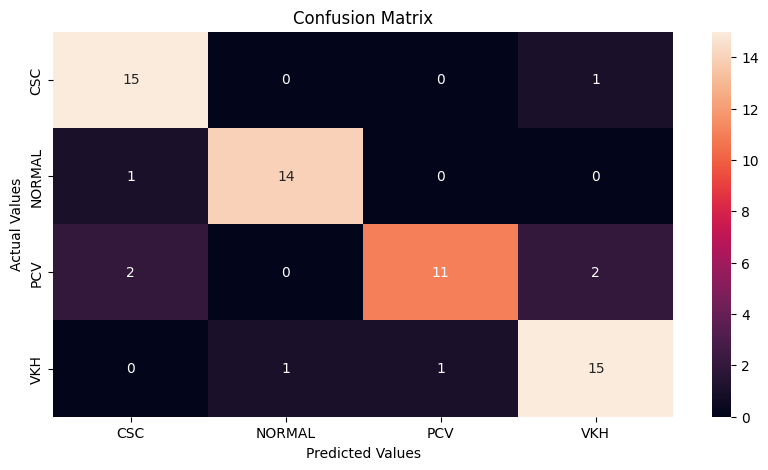

In [46]:
plt.figure(figsize=(10,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
     

##  misclassify

In [47]:
# แสดง misclassify ว่ามีกี่ค่า
misclassify = 0
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:
            misclassify += cm[i][j]
            
print('misclassification: ', misclassify)

misclassification:  8


In [48]:
# คำนวณค่า misclassification
misclassify = 1 - np.trace(cm) / np.sum(cm)

# Misclassification rate = จำนวนภาพที่ถูกจัดหมวดหมู่ผิด / จำนวนภาพทั้งหมดที่ใช้ในการทดสอบ

# แสดงผลลัพธ์ที่คิดเป็น %
print("Misclassification: {:.2f}%".format(misclassify*100))

Misclassification: 12.70%


In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [50]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.873016


In [51]:
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Recall: %f' % recall)

Recall: 0.873016


In [52]:
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Precision: %f' % precision)

Precision: 0.876984


In [53]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('F1 score: %f' % f1)

F1 score: 0.871608


In [54]:
test_set_ = test_set.unbatch()

In [55]:
test_set.file_paths

['/content/drive/My Drive/focusnew/test/PCV/filtered_AU8008 01-07-16 RE_000_cropped.png',
 '/content/drive/My Drive/focusnew/test/NORMAL/filtered_CP9571 30-07-20 RE_000_cropped.png',
 '/content/drive/My Drive/focusnew/test/PCV/filtered_BL9883 25-08-15 LE_002_cropped.png',
 '/content/drive/My Drive/focusnew/test/CSC/filtered_EV7009 23-11-17 RE_000_cropped.png',
 '/content/drive/My Drive/focusnew/test/VKH/filtered_ID2431 11-05-12 LE_000_cropped.png',
 '/content/drive/My Drive/focusnew/test/PCV/filtered_AW9249 03-31-12 RE_000_cropped.png',
 '/content/drive/My Drive/focusnew/test/NORMAL/filtered_CI9575 27-05-18 LE_002_cropped.png',
 '/content/drive/My Drive/focusnew/test/PCV/filtered_AT4636 23-12-16 LE_000_cropped.png',
 '/content/drive/My Drive/focusnew/test/VKH/filtered_IW1417 15-12-14 LE_002_cropped.png',
 '/content/drive/My Drive/focusnew/test/PCV/filtered_BF9378 01-11-18 LE_001_cropped.png',
 '/content/drive/My Drive/focusnew/test/NORMAL/filtered_AA0598 17-11-22 RE_000_cropped.png',
 

In [56]:
import shutil

In [59]:
misclass_path = '/misclassify_modelOCTnoiseRes2'
if not os.path.exists(path+misclass_path):
    os.makedirs(path+misclass_path)

for myFilename in test_set.file_paths:

  tempfn = myFilename.split('/')
  myTrueVal = tempfn[6]
  mySubjID = tempfn[7].rstrip('_cropped.png')

  test_path = (myFilename)
  img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
    )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = predict_model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  if score[0]==np.max(score):
    eye = "CSC"
  elif score[1]==np.max(score):
    eye = "NORMAL"
  elif score[2]==np.max(score):
    eye = "PCV"
  elif score[3]==np.max(score):
    eye = "VKH"
  myConfid = np.round(100 * np.max(score),2)
  myPredVal = eye 

  if myTrueVal != myPredVal:
    fn = mySubjID+'__true-'+myTrueVal+'__pred-'+myPredVal+'__'+str(myConfid)+'.png'
    print(fn)
    shutil.copyfile(myFilename, path+misclass_path+'/'+fn)

1/1 [==============================] - 0s 265ms/step
filtered_BL9883 25-08-15 LE_002__true-PCV__pred-CSC__47.54.png
1/1 [==============================] - 0s 290ms/step
filtered_AZ8613 10-02-15 RE_001__true-PCV__pred-VKH__47.5.png
1/1 [==============================] - 0s 272ms/step
filtered_JA1963 17-07-15 RE_002__true-VKH__pred-NORMAL__33.9.png
1/1 [==============================] - 0s 264ms/step
filtered_CJ5901 24-01-19 RE_000__true-NORMAL__pred-PCV__47.16.png
1/1 [==============================] - 1s 797ms/step
filtered_CI9575 27-05-18 RE_000__true-NORMAL__pred-CSC__47.53.png
1/1 [==============================] - 0s 433ms/step
filtered_FF9561 19-10-17 RE_000__true-CSC__pred-NORMAL__41.89.png
1/1 [==============================] - 1s 554ms/step
filtered_J_S_000__true-VKH__pred-PCV__47.54.png
1/1 [==============================] - 0s 492ms/step
filtered_AV0940 01-06-12 RE_000__true-PCV__pred-VKH__47.54.png
1/1 [==============================] - 1s 538ms/step
filtered_AY7496 08-31-17